Code von der Blog Seite: 
    http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
    
Things to try:
* Batch Normalization
* Dropout
* LSTM longer
* More Layers
* Scale of Data (z-Transformation)

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import pandas as pd
import time
import datetime
%matplotlib inline

def dateparse (ts_str):    
    return datetime.datetime.strptime(ts_str, '%Y%m%d_%H:%M:%S')

df = pd.read_csv('data/LU_dat/VSP_86303/all_together.csv.gz', compression='gzip', index_col='timestamp', parse_dates=True, date_parser=dateparse)

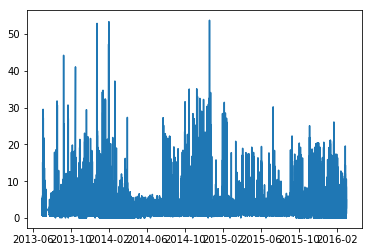

In [2]:
dataset = df[df['PQ_SVCT'] < 15000]['PQ_SVCT']
plt.plot(dataset)
plt.show()

In [3]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import TimeDistributed
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [4]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [5]:
# load the dataset
dataframe = dataset = df[df['PQ_SVCT'] < 15000]['PQ_SVCT']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [6]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [7]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
print(len(train), len(test))

177058 87208


In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return numpy.array(dataX), numpy.array(dataY)

In [28]:
# reshape into X=t and Y=t+1
look_back = 10
train_X, train_Y = create_dataset(train, look_back)
test_X, test_Y = create_dataset(test, look_back)

In [30]:
test_X

array([[ 0.0224858 ,  0.02934792,  0.03675926, ...,  0.03196612,
         0.03709528,  0.02002791],
       [ 0.02934792,  0.03675926,  0.03222837, ...,  0.03709528,
         0.02002791,  0.02390709],
       [ 0.03675926,  0.03222837,  0.03328696, ...,  0.02002791,
         0.02390709,  0.01915136],
       ..., 
       [ 0.03570437,  0.04016875,  0.07308899, ...,  0.06363191,
         0.09945931,  0.06808458],
       [ 0.04016875,  0.07308899,  0.06841649, ...,  0.09945931,
         0.06808458,  0.06248099],
       [ 0.07308899,  0.06841649,  0.06991841, ...,  0.06808458,
         0.06248099,  0.07665111]], dtype=float32)

In [29]:
test_Y

array([ 0.02390709,  0.01915136,  0.02004223, ...,  0.06248099,
        0.07665111,  0.10568947], dtype=float32)

In [42]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
testX = numpy.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
trainY = train_Y
testY = test_Y

In [40]:
train_Y

array([ 0.0360194 ,  0.08825094,  0.07097638, ...,  0.02425436,
        0.02389174,  0.02604688], dtype=float32)

In [41]:
test_Y

array([ 0.02390709,  0.01915136,  0.02004223, ...,  0.06248099,
        0.07665111,  0.10568947], dtype=float32)

In [60]:
# create and fit the LSTM network
print(len(train))
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))#, return_sequences=True))
#model.add(LSTM(128, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1))
#model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

177058
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 128)               71168     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 71,809.0
Trainable params: 71,553.0
Non-trainable params: 256.0
_________________________________________________________________


In [61]:
model.fit(trainX, trainY, epochs=100, batch_size=128, verbose=2)

Epoch 1/100
12s - loss: 9.1838e-04
Epoch 2/100
11s - loss: 4.8058e-04
Epoch 3/100
11s - loss: 4.4408e-04
Epoch 4/100
11s - loss: 4.4052e-04
Epoch 5/100
11s - loss: 4.3903e-04
Epoch 6/100
14s - loss: 4.4318e-04
Epoch 7/100
11s - loss: 4.4470e-04
Epoch 8/100
11s - loss: 4.3383e-04
Epoch 9/100
11s - loss: 4.3774e-04
Epoch 10/100
11s - loss: 4.3252e-04
Epoch 11/100
11s - loss: 4.3650e-04
Epoch 12/100
12s - loss: 4.3415e-04
Epoch 13/100
11s - loss: 4.3453e-04
Epoch 14/100
12s - loss: 4.3247e-04
Epoch 15/100
2445s - loss: 4.3562e-04
Epoch 16/100
12s - loss: 4.3281e-04
Epoch 17/100
11s - loss: 4.3760e-04
Epoch 18/100
11s - loss: 4.3374e-04
Epoch 19/100
13s - loss: 4.3473e-04
Epoch 20/100
11s - loss: 4.3284e-04
Epoch 21/100
11s - loss: 4.3521e-04
Epoch 22/100
12s - loss: 4.3391e-04
Epoch 23/100
11s - loss: 4.3295e-04
Epoch 24/100
12s - loss: 4.2995e-04
Epoch 25/100
11s - loss: 4.3181e-04
Epoch 26/100
12s - loss: 4.3062e-04
Epoch 27/100
11s - loss: 4.3431e-04
Epoch 28/100
12s - loss: 4.3078e-04

In [62]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
invTrainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
invTestY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(invTrainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(invTestY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.09 RMSE
Test Score: 1.10 RMSE


/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


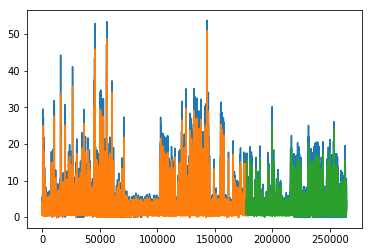

In [63]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = np.reshape(trainPredict, len(trainPredict))
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = np.reshape(testPredict, len(testPredict))
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


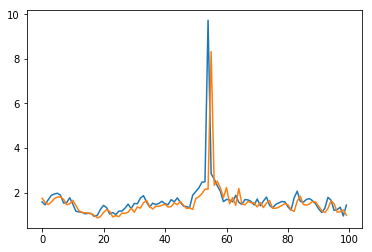

In [64]:
plt.plot(scaler.inverse_transform(dataset)[200000:200100])
plt.plot(testPredictPlot[200000:200100])

In [65]:
scaler.inverse_transform(dataset)[len(trainPredictPlot):len(trainPredictPlot)+100]
print(len(trainPredictPlot))
print(len(dataset))

264266
264266


/usr/local/lib/python3.5/site-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [66]:
model.save('LA40.h5')